In [5]:
import time
import sys
from subprocess import call
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import numpy as np

In [6]:
# import os
# import tensorflow as tf
# from tensorflow import keras
# import qkeras
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
# from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Add
# from tensorflow.keras.regularizers import l1_l2
# from qkeras.qlayers import QDense, QActivation
# from qkeras.qconvolutional import QConv2D
# from qkeras.qconv2d_batchnorm import QConv2DBatchnorm
# from qkeras.qpooling import QAveragePooling2D
# from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import accuracy_score
import keras

In [7]:
# UPLOAD MODEL
# path to model relative to downsample_tb.py
model_file_path = "../training/trained_model/model_best.h5"
co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model(model_file_path, custom_objects = co)

# # print model summary
# print(model.summary())

In [8]:
# take any input img, do largest square center crop if not input not square,
# and return a square img of dimsxdims
def downsamp(img, dims):
    smallest_dim = np.min(np.array([img.shape[0], img.shape[1]]))

    # center crop relative to this image, so that we have square image
    img_sq = img[int(img.shape[0]/2)-int(smallest_dim/2):int(img.shape[0]/2)+int(smallest_dim/2),
                int(img.shape[1]/2)-int(smallest_dim/2):int(img.shape[1]/2)+int(smallest_dim/2),
                :]

    # interpolate to make image 32x32x3
    res = cv2.resize(img_sq, dsize=(dims, dims), interpolation=cv2.INTER_NEAREST)
    
    return res

In [ ]:
# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         print(filename)   # use this to create y_dtest!!!!
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)
#     return np.array(images)

In [ ]:
# print("Icon Images Uploaded: ")
# X_dtest_1 = load_images_from_folder("./icon_lib")
# icon_ims = []
# for elem in X_dtest_1:
#     icon_ims.append(downsamp(elem, 128))

# icon_ims = np.array(icon_ims)
# np.save("icon_ims.npy", icon_ims)
   

In [ ]:
# icon_ims_1 = np.load('icon_ims.npy')
# plt.imshow(icon_ims_1[6])

In [ ]:
# # plane_img_original = cv2.imread('./airplane_vector.png')
# # dims = 128
# # plane_downsamp = downsamp(plane_img_original, dims)

# icon_mask = []

# for elem in icon_ims_1:
#     plane_img = 255 - elem
#     mask = np.ones((480,640, 3), np.uint8)
#     mask[0:128, -128:] = plane_img[0:128,0:128,:]
#     icon_mask.append(mask)

# icon_mask = np.array(icon_mask)
# np.save("icon_mask.npy", icon_mask)

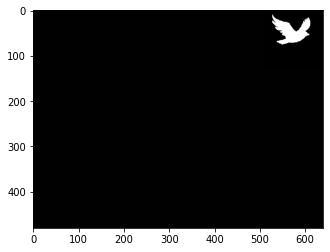

In [9]:
icon_mask = np.load("icon_mask.npy")
plt.imshow(icon_mask[2])

In [10]:
# RUN THE MODEL ITERATIVELY AND EVALUATE THE FRAME USING NEURAL NET
# PRESS STOP TO PREVENT THE MODEL FROM CONTINUING
# MODEL PREDICTION SHOWN AS AN ICON ON THE TOP LEFT OF THE SCREEN

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(1)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        
        '''
        send the image to the accelerator here
        '''
        res = downsamp(frame, 32)
        
        # convert to input ready for neural net
        X_dtest = np.ascontiguousarray(res, dtype=np.float32)  # doesn't change shape, just turns every element to float instead of int
        X_dtest = X_dtest/256.

        # have model predict the image
        y_pred = model.predict(np.array([X_dtest]))
        
        # print 

        mask = icon_mask[np.argmax(y_pred[0])]
        
        # print("frame size is :", frame.shape)
        # print("mask size is : ", mask.size)
        frame = cv2.subtract(frame, mask)
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

None